In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

In [2]:
dd=pd.read_csv("Bengaluru_House_Data.csv")
dd.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
dd.shape

(13320, 9)

In [4]:
dd.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [5]:
dd1=dd.drop(['area_type','society','balcony','availability'],axis='columns')
dd1.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


# Data Cleaning

In [7]:
dd1.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [8]:
dd2=dd1.dropna()
dd2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [9]:
dd2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

BHK, bedroom; different names in same feature. Now we have to fix it.

In [10]:
dd2['bhk']=dd2['size'].apply(lambda x: int(x.split(' ')[0]))

C:\Users\user\AppData\Local\Temp\ipykernel_27652\3658387775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd2['bhk']=dd2['size'].apply(lambda x: int(x.split(' ')[0]))


In [11]:
dd2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [12]:
dd2['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [13]:
dd2[dd2.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


2400 sqft with 43 rooms looking like an error. We'll fix it letter.

In [14]:
dd2.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

can't have range here. have to fix it.

In [15]:
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True

In [16]:
dd2[~dd2['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Now, ignoring sq.meter or perch values and taking the average of range values

In [18]:
def convert_sqft_to_num(x):
  tokens=x.split('-')
  if len(tokens)==2:
    return (float(tokens[0])+float(tokens[1]))/2
  try:
    return float(x)
  except:
    return None

In [19]:
convert_sqft_to_num('2166')

2166.0

In [20]:
convert_sqft_to_num('2100-2850')

2475.0

In [21]:
convert_sqft_to_num('4125Perch')

If sqft is 4125 Perch it's returning nothing. That's alright as we have huge number of datas but we can also handle it by converting perch or sq.meter to sqft. 

In [22]:
dd3=dd2.copy()
dd3['total_sqft']=dd3['total_sqft'].apply(convert_sqft_to_num)
dd3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [23]:
dd3.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In 30th index the Total_sqft is the avg of the given range.

In [24]:
dd4=dd3.copy()
dd4['price_per_sqft']=dd4['price']*100000/dd4['total_sqft']
dd4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [25]:
len(dd4['location'].unique())

1304

Now if we use dummy method we will have 1304 features. That is too much. This situation is called dimensionality curse.

To solve this we can create other category where we will have the featues that have very less amount of datapoint.

In [26]:
dd4.location=dd4.location.apply(lambda x: x.strip()) #It will remove any extra space
location_stats=dd4.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

Any location that has less then 10 datapoints, we will put that into "Other"

In [27]:
len(location_stats[location_stats<=10])

1052

In [28]:
location_stats_less_then_10=location_stats[location_stats<=10]
location_stats_less_then_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [29]:
len(dd4.location.unique())

1293

In [30]:
dd4.location=dd4.location.apply(lambda x: 'other' if x in location_stats_less_then_10 else x)
len(dd4.location.unique())

242

In [31]:
dd4.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


# ***Now, Outlier detection and removal.***

The bhk and sqft of the houses should make sense. We should fix it. Let's assume typical sqft per bedroom is 300sqft.

In [32]:
dd4[dd4.total_sqft/dd4.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [33]:
dd4.shape

(13246, 7)

By "~" we will negate.

In [34]:
dd5=dd4[~(dd4.total_sqft/dd4.bhk<300)]
dd5.shape

(12502, 7)

In [35]:
dd5.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

Min and max prices are extreme datapoint. And we need to remove these.

We need to check it oer location because prices varies in different locations.

In [36]:
def remove_pps_outliers(dd):
  dd_out=pd.DataFrame()
  for key,subdf in dd.groupby('location'):
    m=np.mean(subdf.price_per_sqft)
    st=np.std(subdf.price_per_sqft)
    reduced_dd=subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
    dd_out=pd.concat([dd_out,reduced_dd],ignore_index=True)
  return dd_out

dd6=remove_pps_outliers(dd5)
dd6.shape

(10241, 7)

Now, we need to check if the property prices of 3bhk are more then 2bhk for the same sqft area or not. If it's not, we need to remove those as they are errors.

We can check these scatter plots for different locations.

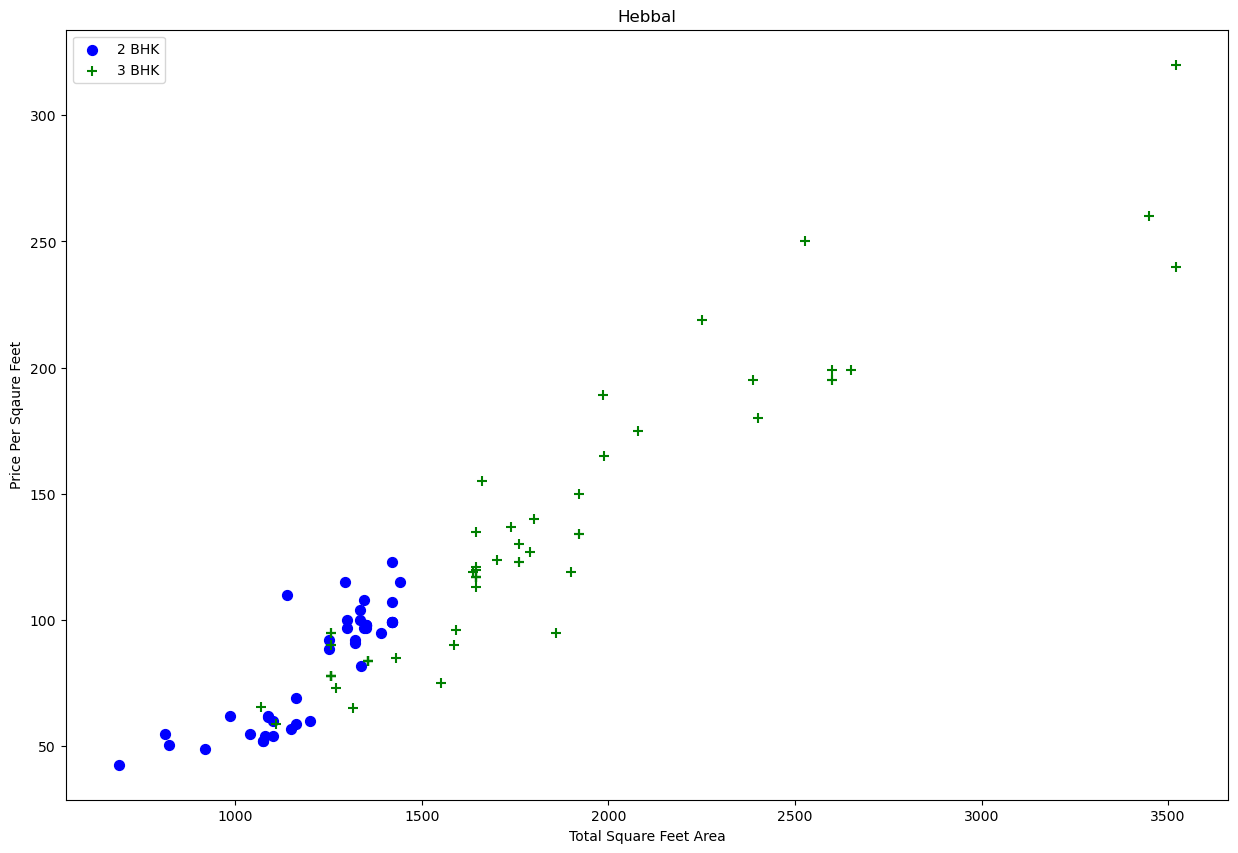

In [37]:
def plot_scatter_chart(dd,location):
  bhk2=dd[(dd.location==location) & (dd.bhk==2)]
  bhk3=dd[(dd.location==location) & (dd.bhk==3)]
  matplotlib.rcParams['figure.figsize']=(15,10)
  plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK',s=50)
  plt.scatter(bhk3.total_sqft,bhk3.price,marker='+',color='green',label='3 BHK',s=50)
  plt.xlabel("Total Square Feet Area")
  plt.ylabel("Price Per Sqaure Feet")
  plt.title(location)
  plt.legend()

plot_scatter_chart(dd6,"Hebbal")

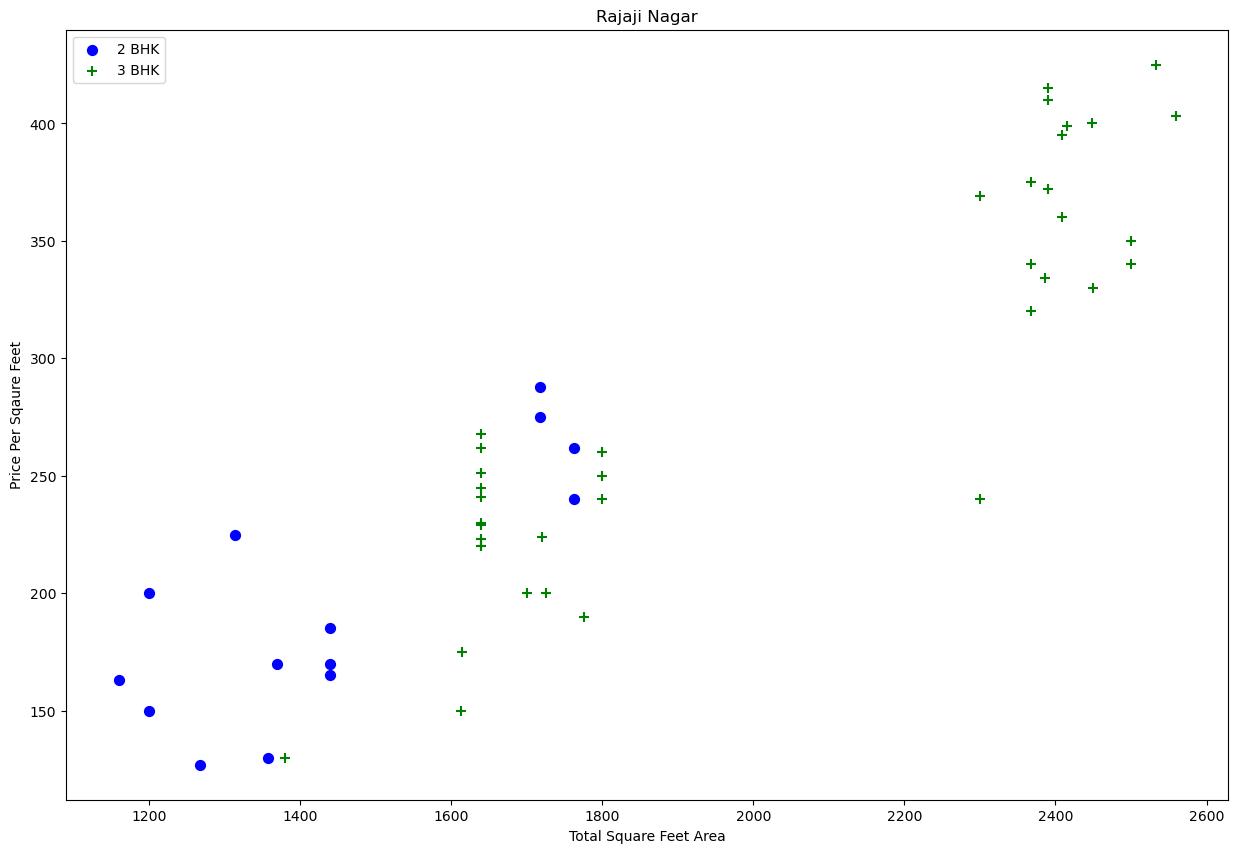

In [38]:
plot_scatter_chart(dd6,"Rajaji Nagar")

Now, we need to remove 3Bhk apartments whoose price_per_sqft is less than mean price_per_sqft of 2Bhk apartment.

Like this,we need to remove 2Bhk apartments whoose price_per_sqft is less than mean price_per_sqft of 1Bhk apartment.

In this process, We need to remove all this kinds of errors.

In [39]:
def remove_bhk_outliers(dd):
  exclude_indices=np.array([])
  for location, location_dd in dd.groupby('location'):
    bhk_stats={}
    for bhk, bhk_dd in location_dd.groupby('bhk'):
      bhk_stats[bhk]={
        'mean': np.mean(bhk_dd.price_per_sqft),
        'std': np.std(bhk_dd.price_per_sqft),
        'count': bhk_dd.shape[0]
    }
    for bhk,bhk_dd in location_dd.groupby('bhk'):
      stats=bhk_stats.get(bhk-1)
      if stats and stats['count']>5:
        exclude_indices=np.append(exclude_indices,bhk_dd[bhk_dd.price_per_sqft<(stats['mean'])].index.values)
  return dd.drop(exclude_indices,axis='index')

dd7=remove_bhk_outliers(dd6)
dd7.shape

(7329, 7)

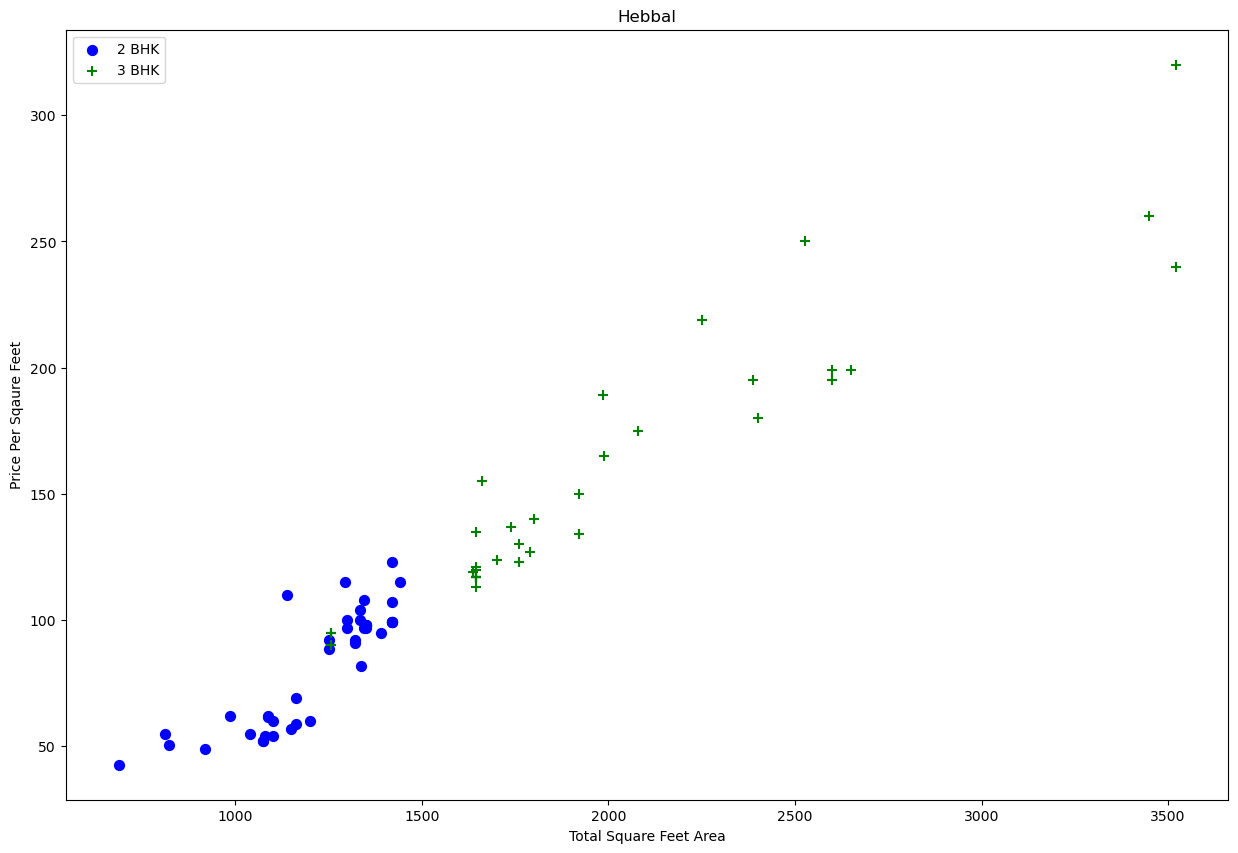

In [40]:
plot_scatter_chart(dd7,"Hebbal")

Now we can see that many green datapoints are gone now.

Text(0, 0.5, 'Count')

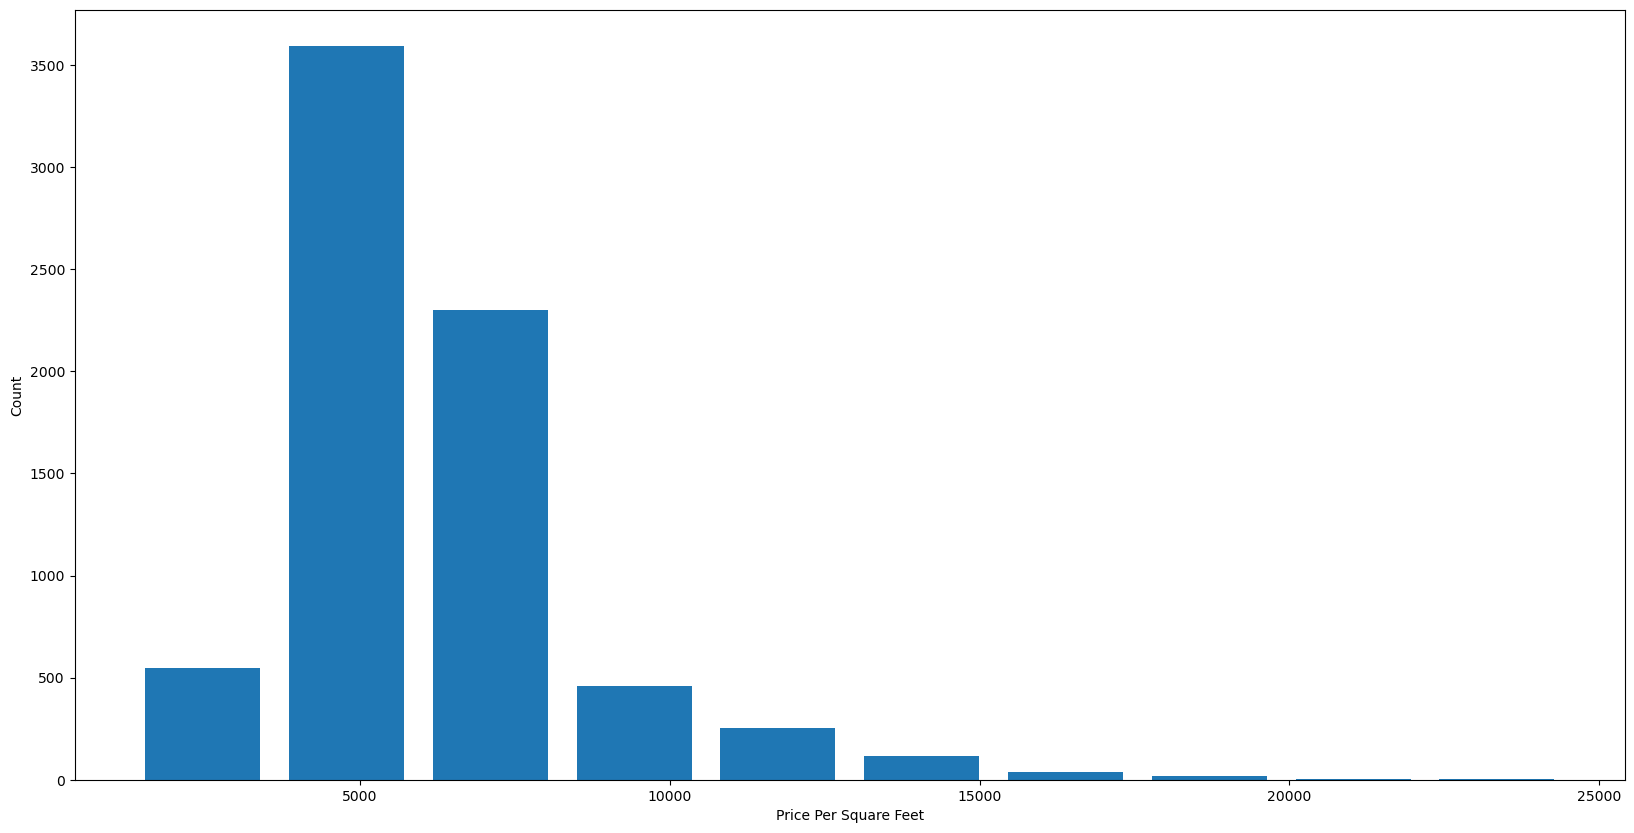

In [41]:
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
plt.hist(dd7.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

So, from 0-10000 rupies per square feet I have majority of my datapoints.

In [42]:
dd7.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [43]:
dd7[dd7.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


There are some property where no. of bathroom is much greater then no. of bedrooms. So, we need to remove the datapoints where no. of bathroom is greater then no. of bedrooms+2.

Text(0, 0.5, 'Count')

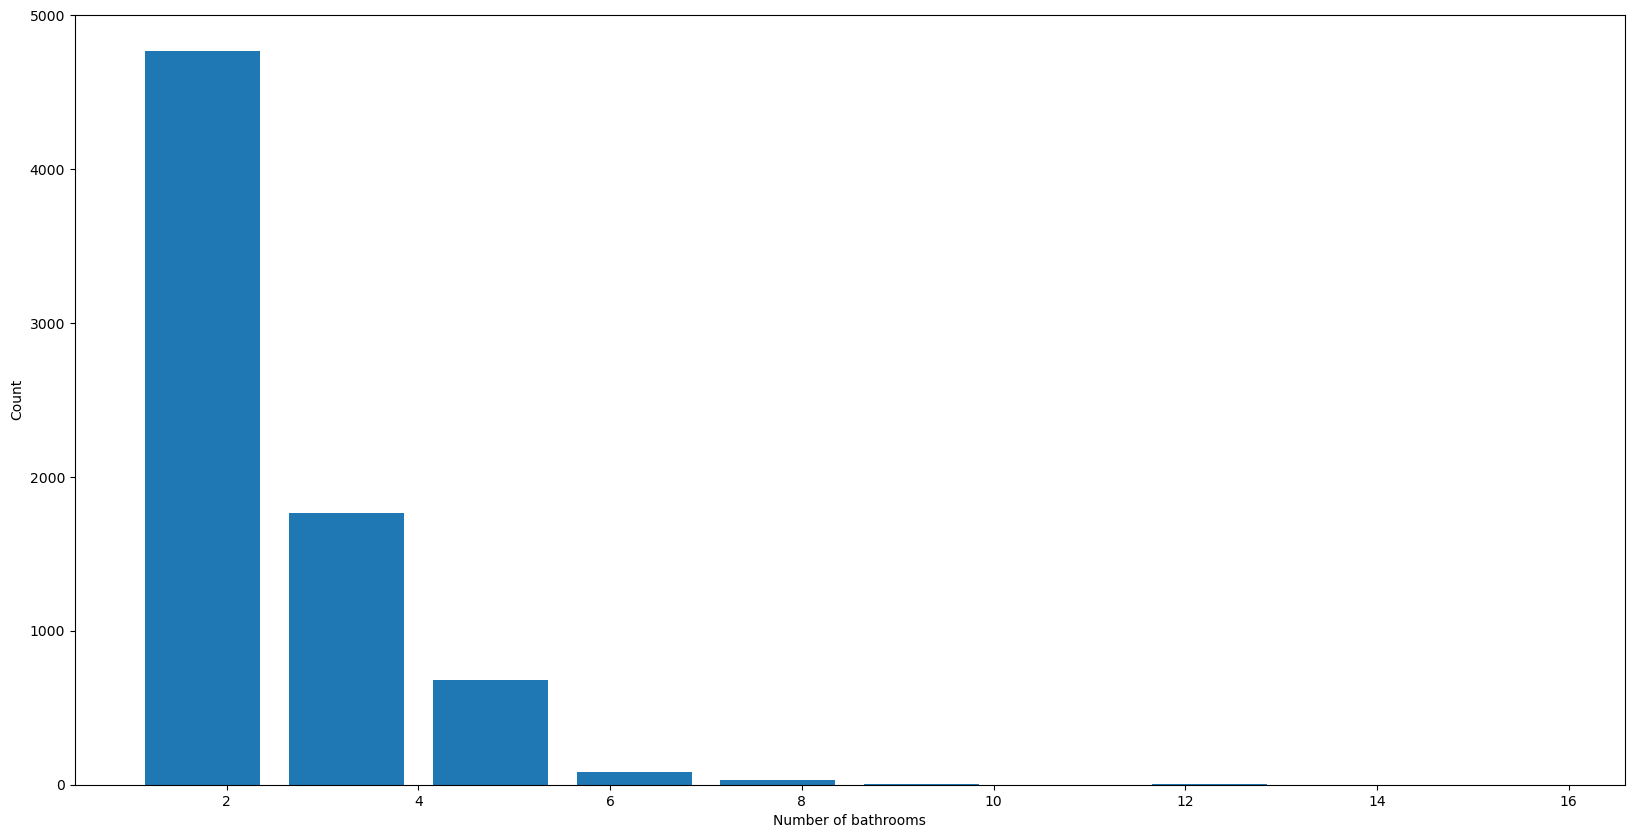

In [44]:
plt.hist(dd7.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [45]:
dd7[dd7.bath>dd7.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


These are outliers we need to remove.

In [46]:
dd8=dd7[dd7.bath<dd7.bhk+2]
dd8.shape

(7251, 7)

Now, Before machine learning we can drop unnecessary features. We will drop size as we have bhk. And we will also drop price_per_sqft as we needed this just to detect outliers.

In [47]:
dd9=dd8.drop(['size','price_per_sqft'],axis='columns')
dd9.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [48]:
dummies=pd.get_dummies(dd9.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
dd10=pd.concat([dd9,dummies.drop('other',axis='columns')],axis='columns')
dd10.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
dd11=dd10.drop('location',axis='columns')
dd11.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
dd11.shape

(7251, 245)

In [53]:
x=dd11.drop('price',axis='columns')
x.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
y=dd11.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [55]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=10)

In [56]:
from sklearn.linear_model import LinearRegression
lr_clf=LinearRegression()
lr_clf.fit(x_train,y_train)
lr_clf.score(x_test,y_test)

0.8452277697874312

In [57]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
cross_val_score(LinearRegression(),x,y,cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(x,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(x,y)


C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py", line 

,model,best_score,best_params
0,linear_regression,0.818354,{}
1,lasso,0.687457,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.712196,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


# So, Linear Regression model is the best one for this project

In [61]:
x.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [62]:
np.where(x.columns=='2nd Phase Judicial Layout')[0][0]

5

In [63]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(x.columns==location)[0][0]

    X = np.zeros(len(x.columns))
    X[0] = sqft
    X[1] = bath
    X[2] = bhk
    if loc_index >= 0:
        X[loc_index] = 1

    return lr_clf.predict([X])[0]

Let's check

In [64]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.49904677179237

In [65]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


86.80519395205847

In [66]:
predict_price('Indira Nagar',1000, 2, 2)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


181.2781548400685

In [67]:
predict_price('Indira Nagar',1000, 3, 3)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


184.58430202033463

# Exporting to a pickle file

In [68]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
  pickle.dump(lr_clf,f)

In [69]:
import json
columns={
    'data_columns':[col.lower() for col in x.columns]
}
with open("Columns.json","w") as f:
    f.write(json.dumps(columns))